# About the Project

This project focuses on predicting hotel booking cancellations using a real-world dataset of hotel reservations publicy available through [Kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand). The aim is to build a robust classification model that can accurately identify whether a booking is likely to be canceled based on various customer, booking, and stay-related features.

The workflow involves detailed data preprocessing and feature engineering to handle missing values, outliers, and data imbalances. Several machine learning models were evaluated, including Logistic Regression, Random Forest, XGBoost, and LightGBM, with hyperparameter tuning and class imbalance handling. 

Model performance was assessed using classification metrics and ROC AUC scores, with further insights derived from feature importance plots to enhance interpretability. This end-to-end pipeline provides actionable insights for hotel management to anticipate cancellations and optimize operational decisions.

# Data Description

The detailed description of each columns present in the data is as shown below:

| Column Name                      | Description                                                      |
| -------------------------------- | ---------------------------------------------------------------- |
| `hotel`                          | Type of hotel (Resort Hotel or City Hotel)                       |
| `is_canceled`                    | Whether the booking was canceled (1) or not (0)                  |
| `lead_time`                      | Number of days between booking and arrival date                  |
| `arrival_date_year`              | Year of arrival date                                             |
| `arrival_date_month`             | Month of arrival date                                            |
| `arrival_date_week_number`       | Week number of arrival date                                      |
| `arrival_date_day_of_month`      | Day of arrival date                                              |
| `stays_in_weekend_nights`        | Number of weekend nights (Saturday/Sunday) the guest stayed      |
| `stays_in_week_nights`           | Number of week nights (Monday–Friday) the guest stayed           |
| `adults`                         | Number of adults                                                 |
| `children`                       | Number of children                                               |
| `babies`                         | Number of babies                                                 |
| `meal`                           | Type of meal booked                                              |
| `country`                        | Country of origin of the guest                                   |
| `market_segment`                 | Market segment designation (e.g., Online TA, Groups)             |
| `distribution_channel`           | Booking distribution channel (e.g., TA/TO, Direct)               |
| `is_repeated_guest`              | Whether the guest is a repeated customer                         |
| `previous_cancellations`         | Number of previous bookings canceled by the customer             |
| `previous_bookings_not_canceled` | Number of previous bookings not canceled                         |
| `reserved_room_type`             | Code of room type initially reserved                             |
| `assigned_room_type`             | Code of room type actually assigned                              |
| `booking_changes`                | Number of changes made to the booking                            |
| `deposit_type`                   | Type of deposit made (e.g., No Deposit, Refundable)              |
| `agent`                          | ID of the booking agent (or null if not booked through an agent) |
| `company`                        | ID of the company that booked the reservation (if applicable)    |
| `days_in_waiting_list`           | Number of days the booking was on the waiting list               |
| `customer_type`                  | Type of customer (e.g., Contract, Transient)                     |
| `adr`                            | Average Daily Rate: price paid per day per room                  |
| `required_car_parking_spaces`    | Number of car parking spaces requested                           |
| `total_of_special_requests`      | Total number of special requests made by the customer            |
| `reservation_status`             | Status of the reservation (e.g., Canceled, Check-Out)            |
| `reservation_status_date`        | Date when the last reservation status was updated                |


# Loading the Data

In [2]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("hotel_bookings.csv")

In [6]:
data.shape

(119390, 32)

In [7]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

# Data Cleaning and Feature Engineering

### Duplicates

In [8]:
data.duplicated().value_counts()

False    87396
True     31994
Name: count, dtype: int64

The duplicated rows are removed as shown above. We remove the duplicate rows. 

In [9]:
data = data.drop_duplicates()

### Null Values

In [10]:
data.isnull().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                             452
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             12193
company                           82137


There are three columns namely: country, agent and company which have missing values. 

There is another column named children which has four missing values. We remove the rows which have null (unknown) values for children from our data as the number of such rows which will be removed is very small compared to size of the dataset. 

In [11]:
data = data[~data["children"].isnull()]

Because of the very high values in the agent and company column, we cannot remove those rows from the data. We might however be able to remove the rows where the country column is null. Below, we check to see if removing these values remove some typical patters from the data to be sure that we donot lose significant informations. 

In [12]:
data[data['country'].isnull()]['market_segment'].value_counts(normalize=True)

market_segment
Corporate        0.400442
Direct           0.345133
Online TA        0.163717
Offline TA/TO    0.070796
Groups           0.011062
Complementary    0.008850
Name: proportion, dtype: float64

In [13]:
data[data['country'].notnull()]['market_segment'].value_counts(normalize=True)

market_segment
Online TA        0.592857
Offline TA/TO    0.159386
Direct           0.133966
Groups           0.056786
Corporate        0.046365
Complementary    0.008029
Aviation         0.002611
Name: proportion, dtype: float64

Bookings where the country values is not present comes disprotionately from the Corporate and Direct Market. 

In [14]:
data[data['country'].isnull()]['is_canceled'].value_counts(normalize=True)

is_canceled
0    0.924779
1    0.075221
Name: proportion, dtype: float64

In [15]:
data['is_canceled'].value_counts(normalize=True)

is_canceled
0    0.725135
1    0.274865
Name: proportion, dtype: float64

Bookings with missing country values are much less likely to be canceled than typical bookings

There is no significant correlation between relevant columns.

### Data Types

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87392 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87392 non-null  object 
 1   is_canceled                     87392 non-null  int64  
 2   lead_time                       87392 non-null  int64  
 3   arrival_date_year               87392 non-null  int64  
 4   arrival_date_month              87392 non-null  object 
 5   arrival_date_week_number        87392 non-null  int64  
 6   arrival_date_day_of_month       87392 non-null  int64  
 7   stays_in_weekend_nights         87392 non-null  int64  
 8   stays_in_week_nights            87392 non-null  int64  
 9   adults                          87392 non-null  int64  
 10  children                        87392 non-null  float64
 11  babies                          87392 non-null  int64  
 12  meal                            8739

In [17]:
data["children"] = data["children"].astype(int)

Columns such as arrival_date_year, arrival_date_month, arrival_date_week_number, and arrival_date_day_of_month etc which contain temporal information are important but in their current form, they are disjointed. 

In [18]:
data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'])

### Feature engineering

#### Room Change Type

In [19]:
(data["reserved_room_type"] == data["assigned_room_type"]).value_counts(normalize=True)

True     0.849998
False    0.150002
Name: proportion, dtype: float64

That means 85% of the time, guests get the room they reserved, and 15% of the time, they’re assigned a different room. To use that feature in the ML models, a new column is created called room_change_type which will show 0 when the rooms are as requested by the guest, 1 if the room is downgraded, 2 if the room is upgraded. Before doing that, it is imperative to understand the heirachy of rooms. Here, it is done based on the average daily price of rooms of each category. 

In [20]:
data[data['reserved_room_type'] == 'P'].shape[0]

6

There's a room type P which has average daily price as 0. Hotel rooms which are classified as such number 6 in the entire dataset. Below, such rows which have reserved room type as P are removed. 

In [21]:
data = data[data['reserved_room_type'] != 'P']

In [22]:
all_room_types = pd.concat([
    data[["reserved_room_type", "adr"]].rename(columns={"reserved_room_type": "room_type"}),
    data[["assigned_room_type", "adr"]].rename(columns={"assigned_room_type": "room_type"})
])

overall_adr = all_room_types.groupby("room_type")["adr"].mean().sort_values(ascending=False)

room_rank = {room: rank for rank, room in enumerate(overall_adr.index, start=1)}

To better understand pricing trends across room types, the above code combines both reserved and assigned room type data along with their associated Average Daily Rates (ADR). By merging these two contexts, we ensure a more holistic view of how each room type is priced, regardless of whether the room was initially reserved or ultimately assigned. The combined dataset is then used to calculate the overall average ADR per room type. Finally, the room types are ranked in descending order of their average ADR, creating a unified ranking that reflects their relative pricing across all bookings.

In [23]:
room_rank

{'H': 1,
 'G': 2,
 'F': 3,
 'C': 4,
 'E': 5,
 'D': 6,
 'L': 7,
 'A': 8,
 'B': 9,
 'K': 10,
 'I': 11}

In [24]:
def classify_room_change(row):
    reserved = room_rank.get(row["reserved_room_type"], 0)
    assigned = room_rank.get(row["assigned_room_type"], 0)
    
    if reserved == assigned:
        return 1  # same rank
    elif assigned > reserved:
        return 2  # downgraded (got lower-ranked room)
    else:
        return 3  # upgraded (got higher-ranked room)

data["room_change_type"] = data.apply(classify_room_change, axis=1)

#### Lead Time Category

In [25]:
data['lead_time'].describe()

count    87386.000000
mean        79.900373
std         86.053127
min          0.000000
25%         11.000000
50%         49.000000
75%        125.000000
max        737.000000
Name: lead_time, dtype: float64

In [26]:
def lead_time_category(days):
    if days <= 14:
        return 'Short'
    elif days <= 60:
        return 'Medium'
    elif days <= 125:
        return 'Long'
    else:
        return 'Very Long'

data['lead_category'] = data['lead_time'].apply(lead_time_category)

#### Arrival day and Arrival week bins

In [27]:
# binning for arrival_date_day_of_month (3 bins: Early, Mid, Late)
bins_day = [0, 10, 20, 31]
labels_day = ['Early', 'Mid', 'Late']
data['arrival_day_bin'] = pd.cut(data['arrival_date_day_of_month'], bins=bins_day, labels=labels_day, right=True)

# binning for arrival_date_week_number (4 bins roughly quarterly)
bins_week = [0, 13, 26, 39, 53]
labels_week = ['Q1', 'Q2', 'Q3', 'Q4']
data['arrival_week_bin'] = pd.cut(data['arrival_date_week_number'], bins=bins_week, labels=labels_week, right=True)

### Correlations

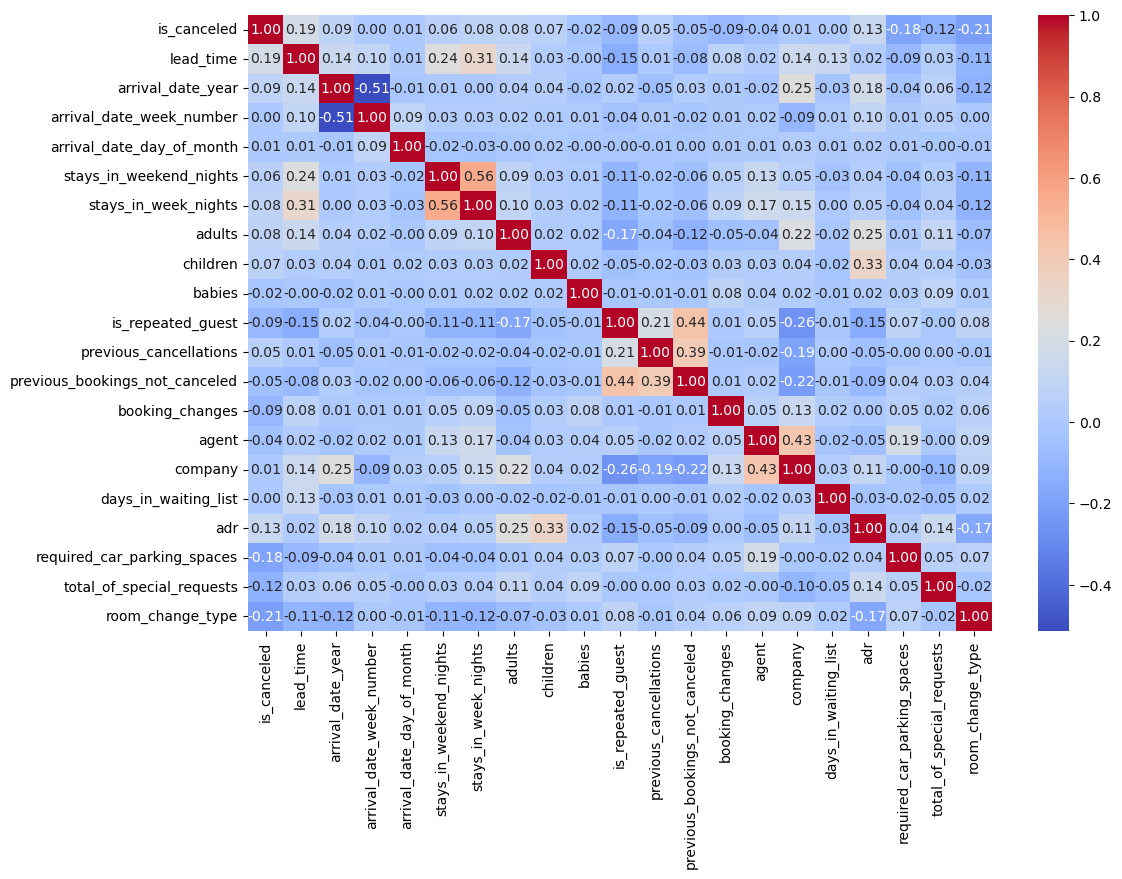

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(data.select_dtypes(include="number").corr(), annot= True, cmap="coolwarm", fmt=".2f")
plt.show()

No significant correlation is observed between different numerical columns.

# Predicting Booking Cancellation

Under this section, we want to predict whether a booking will be cancelled or not using different classification models as enlisted. Before that, we examine the is_canceled column to check for class imbalance

In [29]:
data["is_canceled"].value_counts()

is_canceled
0    63371
1    24015
Name: count, dtype: int64

The class imabalance is not that severe however it is still noticeable (roughly 3:1). Approximately 72% of bookings were not canceled and around 28% of bookings were canceled.

In [30]:
data = data.drop(columns={'company', 'agent', 'country'})

In [31]:
data['reserved_room_rank'] = data['reserved_room_type'].map(room_rank)
data['assigned_room_rank'] = data['assigned_room_type'].map(room_rank)

In [32]:
categorical_cols = ['arrival_date_year', 'arrival_date_month', 'arrival_day_bin', 'arrival_week_bin', 
    'hotel', 'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest',  
    'deposit_type', 'customer_type', 'room_change_type', 'lead_category'
]

# One-hot encoding for categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# We have written drop_first=True in the above code line to avoids dummy variable trap (multicollinearity) for linear models

In [33]:
final_features = [
    'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
    'babies', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes',
    'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
    'total_of_special_requests', 'reserved_room_rank', 'assigned_room_rank',
    
    # One-hot encoded variables
    'arrival_date_year_2016', 'arrival_date_year_2017',
    'arrival_date_month_August', 'arrival_date_month_December',
    'arrival_date_month_February', 'arrival_date_month_January',
    'arrival_date_month_July', 'arrival_date_month_June',
    'arrival_date_month_March', 'arrival_date_month_May',
    'arrival_date_month_November', 'arrival_date_month_October',
    'arrival_date_month_September', 'hotel_Resort Hotel',
    'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined',
    'market_segment_Complementary', 'market_segment_Corporate',
    'market_segment_Direct', 'market_segment_Groups',
    'market_segment_Offline TA/TO', 'market_segment_Online TA',
    'distribution_channel_Direct', 'distribution_channel_GDS',
    'distribution_channel_TA/TO', 'distribution_channel_Undefined', 'is_repeated_guest_1',
    'deposit_type_Non Refund', 'deposit_type_Refundable',
    'customer_type_Group', 'customer_type_Transient',
    'customer_type_Transient-Party', 'room_change_type_2',
    'room_change_type_3', 'lead_category_Medium', 'lead_category_Short', 
    'lead_category_Very Long', 'arrival_day_bin_Mid', 'arrival_day_bin_Late', 
    'arrival_week_bin_Q2', 'arrival_week_bin_Q3', 'arrival_week_bin_Q4', 
]

### Logistics Regression

In [34]:
X = data_encoded[final_features]  
y = data_encoded['is_canceled']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratifying to maintain class ratio
)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
model = LogisticRegression(class_weight='balanced', max_iter=1000) 
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In the above code, class_weight  tells the model to give more importance to the minority class during training without changing the data itself.

In [38]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[8793 3882]
 [1043 3760]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.69      0.78     12675
           1       0.49      0.78      0.60      4803

    accuracy                           0.72     17478
   macro avg       0.69      0.74      0.69     17478
weighted avg       0.78      0.72      0.73     17478

ROC AUC Score: 0.8245171061314819


The Logistic Regression model achieves an overall accuracy of 72%. It demonstrates strong performance in identifying non-canceled bookings (class 0), with a precision of 0.89 and recall of 0.69, indicating that most predictions for non-cancellations are correct. However, the model struggles with detecting canceled bookings (class 1), achieving only 49% precision and 78% recall, which suggests a high false positive rate for cancellations. The F1-score for cancellations is 0.60, pointing to moderate effectiveness in identifying actual cancellations. The ROC AUC Score of 0.82 indicates that the model does a decent job of ranking predictions, though there's clear room for improvement in balancing performance across both classes.

### Tree-based Models

For tree-based models, we donot want to use the one-hot encoded columns. Label encoding is often better for tree-based models which is what we do in the following code chunks.

In [39]:
X = data.drop(columns={'is_canceled', 'lead_time', 'arrival_date_week_number','arrival_date_day_of_month', 'reserved_room_type', 'assigned_room_type', 
                      'reservation_status', 'reservation_status_date'})
y = data['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
categorical_features = [
    'arrival_date_year', 'arrival_week_bin',      
    'arrival_date_month', 'arrival_day_bin',     
    'hotel', 'lead_category',                    
    'meal',                     
    'market_segment',           
    'distribution_channel',      
    'is_repeated_guest',        
    'deposit_type',              
    'customer_type',            
    'room_change_type'           
]

In [41]:
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

### Random Forest

#### Hyperparameter Tuning

In [42]:
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [43]:
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=30,                 
    scoring='roc_auc',
    cv=3,                     
    verbose=2,
    random_state=42,
    n_jobs=-1                  
)

In [44]:
random_search_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:\n", random_search_rf.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters for Random Forest:
 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


#### Model Prediction

In [45]:
best_rf = random_search_rf.best_estimator_

rf_pred = best_rf.predict(X_test)
rf_proba = best_rf.predict_proba(X_test)[:, 1]

print("Tuned Random Forest Results:")
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_proba))

Tuned Random Forest Results:
[[10942  1740]
 [ 1549  3247]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12682
           1       0.65      0.68      0.66      4796

    accuracy                           0.81     17478
   macro avg       0.76      0.77      0.77     17478
weighted avg       0.81      0.81      0.81     17478

ROC AUC: 0.8652977452297879


The Tuned Random Forest model delivers an improved overall accuracy of 81%, outperforming the Logistic Regression model which achieved 72%. It demonstrates more balanced classification across both classes. For non-cancellations (class 0), Random Forest achieves a precision of 0.88 and recall of 0.86, slightly better than Logistic Regression’s 0.89 precision but notably higher recall of 0.69. More importantly, for cancellations (class 1), Random Forest significantly outperforms Logistic Regression with a precision of 0.65 and recall of 0.68, compared to 0.49 and 0.78 respectively. This reflects fewer false positives and a better trade-off between precision and recall. The F1-score for cancellations rises to 0.66 from 0.60, indicating stronger predictive power. Furthermore, the ROC AUC improves to 0.87, suggesting that the Random Forest model ranks predictions more effectively and handles class imbalance more robustly than Logistic Regression.

### Model Interpretability

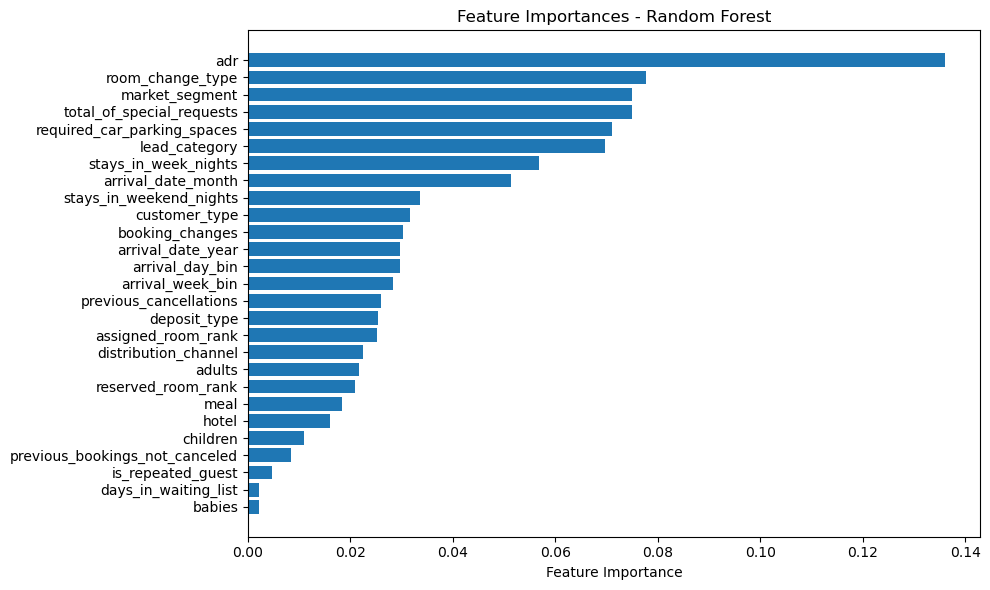

In [52]:
importances = best_rf.feature_importances_
features = X_train.columns  

feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
plt.xlabel("Feature Importance")
plt.title("Feature Importances - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The feature importance plot generated from the tuned Random Forest model highlights the most influential predictors for hotel booking cancellations. Notably, adr (average daily rate), total_of_special_requests, and customer_type emerged as the top three contributors to the model's decisions. Features like previous_bookings_not_canceled, lead_category, and required_car_parking_spaces also held moderate importance, suggesting behavioral and booking context play a significant role.

### XGBoost

#### Hyperparameter Tuning

In [47]:
# Define model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, )

# Define parameter grid
param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.5, 1, 2]
}

In [48]:
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,                    
    scoring='roc_auc',
    cv=3,                        
    verbose=2,
    random_state=42,
    n_jobs=-1                    
)

In [49]:
random_search.fit(X_train, y_train)

print("Best Parameters:\n", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters:
 {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


In [50]:
best_xgb = random_search.best_estimator_

xgb_pred = best_xgb.predict(X_test)
xgb_proba = best_xgb.predict_proba(X_test)[:, 1]

print("XGBoost (Tuned) Results:")
print(classification_report(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb_proba))

XGBoost (Tuned) Results:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     12682
           1       0.73      0.56      0.63      4796

    accuracy                           0.82     17478
   macro avg       0.79      0.74      0.76     17478
weighted avg       0.82      0.82      0.82     17478

ROC AUC: 0.8688972957409837


The tuned XGBoost model achieved an overall accuracy of 82%, outperforming the logistic regression model and closely matching the performance of the tuned Random Forest. It demonstrated strong ability in identifying non-cancellations (class 0), with a high recall of 0.92 and F1-score of 0.88, suggesting that it effectively captures the majority of actual non-cancelled bookings. However, its performance on cancellations (class 1) is more modest, with a recall of 0.56, indicating it still misses a considerable portion of actual cancellations. The precision for class 1 is 0.73, which is higher than in the logistic regression model, meaning that when the model predicts a cancellation, it is more likely to be correct. Overall, the model balances performance across classes better than logistic regression, but still falls slightly behind the Random Forest in terms of recall for class 1.

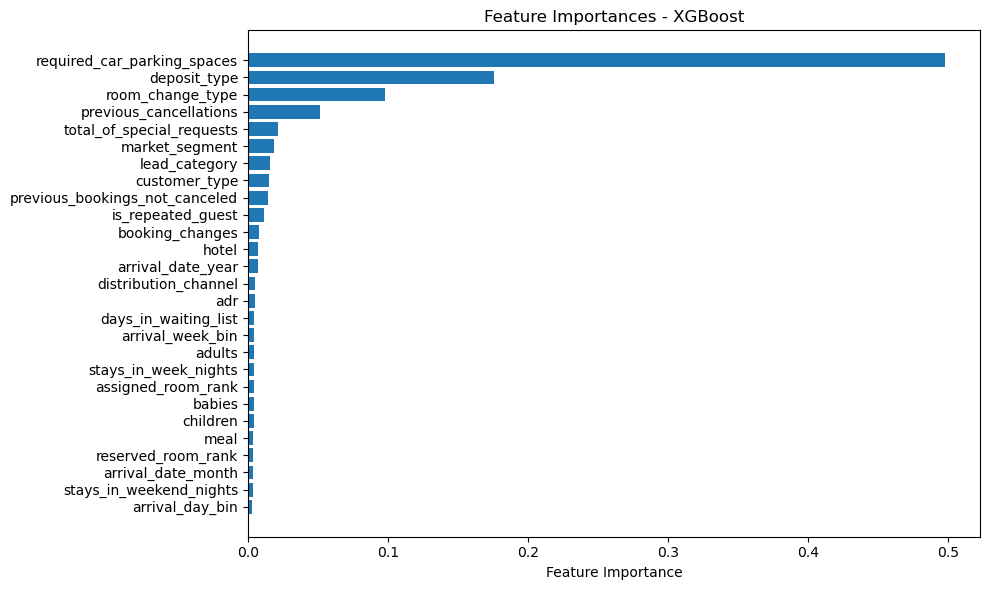

In [60]:
importances = best_xgb.feature_importances_
features = X_train.columns

feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
plt.xlabel("Feature Importance")
plt.title("Feature Importances - XGBoost")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The feature importance plot generated from the XGBoost model highlights the most influential predictors for hotel booking cancellations. Notably, required car parking spaces, deposit type, room change type. Features like previos cancellations, market segment, special request and lead_category,  held moderate importance. 

#### LightGBM

### Hyperparameter Tuning

In [54]:
param_dist_lgb = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 50, 100],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [55]:
lgb_base = LGBMClassifier(class_weight='balanced', random_state=42)

In [56]:
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist_lgb,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [57]:
random_search_lgb.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 19219, number of negative: 50689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 69908, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 10, 20, 30],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 200, 500, 1000],
                                        'num_leaves': [15, 31, 50, 100],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [58]:
best_lgb = random_search_lgb.best_estimator_
print("Best LightGBM Parameters:", random_search_lgb.best_params_)

Best LightGBM Parameters: {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 1000, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [59]:
lgb_pred = best_lgb.predict(X_test)
lgb_proba = best_lgb.predict_proba(X_test)[:, 1]

print("Tuned LightGBM Classification Report:")
print(classification_report(y_test, lgb_pred))
print("ROC AUC Score:", roc_auc_score(y_test, lgb_proba))

Tuned LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.84     12682
           1       0.59      0.76      0.66      4796

    accuracy                           0.79     17478
   macro avg       0.74      0.78      0.75     17478
weighted avg       0.81      0.79      0.79     17478

ROC AUC Score: 0.8658152561424589


The Tuned LightGBM model achieved an overall accuracy of 79%, demonstrating strong predictive power across both classes. For non-cancellations (class 0), it produced high precision (0.90) and recall (0.80), indicating reliable identification of confirmed bookings. More notably, for cancellations (class 1), the model achieved a recall of 0.76, which is higher than both the Logistic Regression (0.49) and Random Forest (0.68) models. This makes LightGBM particularly effective at capturing cancellation cases, which are critical from a business perspective. However, its precision for class 1 (0.59) remains moderate, suggesting some false positives. The ROC AUC score of 0.87 reflects the model's strong overall discrimination ability.

Compared to earlier models, LightGBM balances class performance more effectively, improving recall on the minority class while maintaining good overall accuracy, making it a robust choice for this classification task.

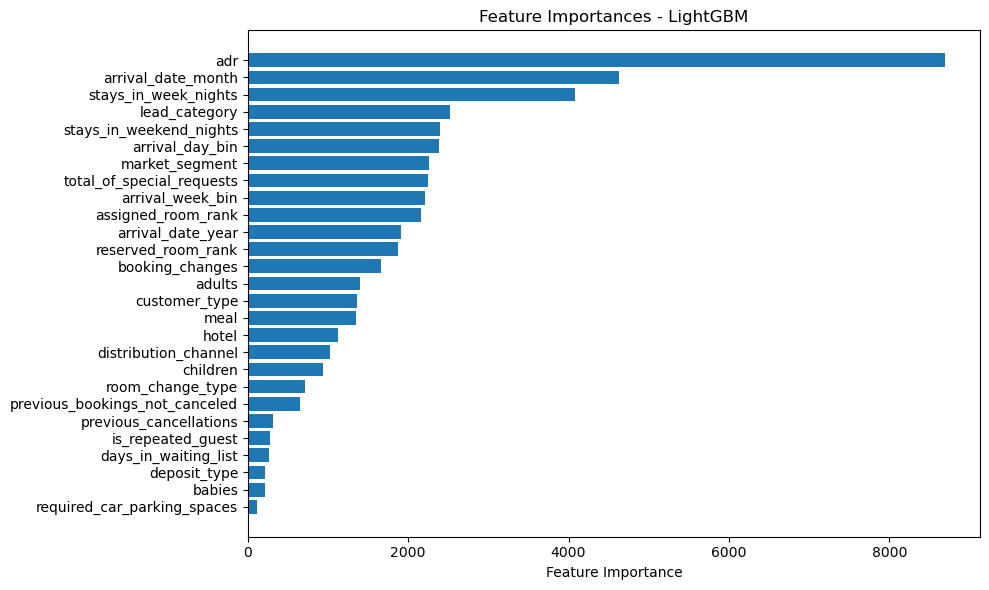

In [61]:
importances = best_lgb.feature_importances_
features = X_train.columns

feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
plt.xlabel("Feature Importance")
plt.title("Feature Importances - LightGBM")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The feature importance plot generated from the LightGBM model highlights the most influential predictors for hotel booking cancellations. Notably, adr, arrival date month and stay in week nights emerged as top three. Features like lead category, stay in weekend nights and arrival day held moderate importance. 

# Conclusion

This project aimed to predict hotel booking cancellations using a combination of exploratory data analysis, feature engineering, and various classification models. After preprocessing and transforming the dataset, multiple machine learning algorithms were evaluated, including Logistic Regression, Random Forest, XGBoost, and LightGBM.

Among these, the Tuned LightGBM model emerged as the most balanced performer, achieving an overall accuracy of 79% and a ROC AUC score of 0.87. It notably outperformed Logistic Regression and Random Forest in identifying cancellations (the minority class), with a recall of 0.76, which is crucial for proactive business decision-making in the hospitality sector.

Feature importance analysis revealed that variables such as average daily rate (adr), special requests, lead time, and room type mismatches had strong predictive power, offering valuable insights into customer behavior.

In conclusion, this model can serve as a valuable decision-support tool for hotel managers to anticipate cancellations and implement strategies such as overbooking management or targeted customer engagement. Future improvements could involve incorporating time-based trends, customer reviews, or external factors such as events or weather conditions to further enhance predictive performance.